In [1]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date
from os.path import join, isfile
from os import listdir
import time
from sklearn.metrics import f1_score
import tensorflow as tf 
from statistics import mode
from itertools import combinations
import pointnet_model

In [2]:
def read_rep(syn, control, syn_csv, ID_csv, data_dir):
    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn)
    ID_dir = data_dir+ "\\{}-selected-{}-controls".format(syn, control)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]
    
    data_syn, data_ID, labels_syn, labels_ID = [], [], [], []
    
    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_syn: 
                rep = list(map(float, row[1:]))
                data_syn.append(rep)
                labels_syn.append(1)

    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_ID:
                rep = list(map(float, row[1:]))
                data_ID.append(rep)
                labels_ID.append(0)
            
    return np.array(data_syn), np.array(data_ID), np.array(labels_syn), np.array(labels_ID)

In [3]:
def read_rep_landmarks(syn, control, syn_csv, ID_csv, data_dir):
    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn)
    ID_dir = data_dir+ "\\{}-selected-{}-controls".format(syn, control)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]

    data_syn, data_ID, labels_syn, labels_ID = [], [], [], []

    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_syn:
                rep = []
                i = 1
                while i < len(row[1:]):
                    rep.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    i+=3                       
                data_syn.append(rep)
                labels_syn.append(1)

    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_ID:
                rep = []
                i = 1
                while i < len(row[1:]):
                    rep.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    i+=3                       
                data_ID.append(rep)
                labels_ID.append(0)

    return np.array(data_syn), np.array(data_ID), np.array(labels_syn), np.array(labels_ID)

In [4]:
def read_rep_oc(syn, control, syn_csv, ID_csv, data_dir):    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn)
    ID_dir = data_dir+ "\\{}-selected-{}-controls".format(syn, control)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]
    print("len files syn", len(files_syn))
    print("len files ID", len(files_ID))
    
    data_syn, data_ID = [], []

    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            if row[0] in files_syn:
                data_syn.append(row)
                    
    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            if row[0] in files_ID:
                data_ID.append(row)
    
    print("len data syn", len(data_syn))
    print("len data ID", len(data_ID))
    
    return np.array(data_syn), np.array(data_ID)

In [5]:
def combine_openface_cfps(syn, control, data_dir):             
                
    method = "openface"
    syn_csv = data_dir+"\\representations\\{}-patients-{}.csv".format(syn, method)
    ID_csv  = data_dir+"\\representations\\{}-controls-{}.csv".format(control, method)
    data_syn_of, data_ID_of = read_rep_oc(syn, control, syn_csv, ID_csv, data_dir)
                
    method = "cfps"
    syn_csv = data_dir+"\\representations\\{}-patients-{}.csv".format(syn, method)
    ID_csv  = data_dir+"\\representations\\{}-controls-{}.csv".format(control, method)
    data_syn_cfps, data_ID_cfps = read_rep_oc(syn, control, syn_csv, ID_csv, data_dir)
       
    data_syn, data_ID = [], []
    labels = []
    indices_syn, indices_ID = [], []

    for openface_i in data_syn_of:
        img_name = openface_i[0]
        if img_name in data_syn_cfps[:,0]:
            index = data_syn_cfps[:,0].tolist().index(img_name)
            
            data_syn.append(openface_i[1:].tolist() + data_syn_cfps[index,1:].tolist())  
    
    for openface_i in data_ID_of:
        img_name = openface_i[0]
        if img_name in data_ID_cfps[:,0]:
            index = data_ID_cfps[:,0].tolist().index(img_name)
            
            data_ID.append(openface_i[1:].tolist() + data_ID_cfps[index,1:].tolist())
    
    if len(data_ID) > len(data_syn):
        data_ID = data_ID[:len(data_syn)]
    else:
        data_syn = data_syn[:len(data_ID)]

    data = data_syn + data_ID
    labels = np.ones(len(data_syn)).tolist() + np.zeros(len(data_ID)).tolist()

    return np.array(data), np.array(labels)

In [6]:
def normalize(data_1, data_2, data_3):
    data_1 = Normalizer().fit_transform(data_1)
    data_2 = Normalizer().fit_transform(data_2)
    data_3 = Normalizer().fit_transform(data_3)
    return data_1, data_2, data_3

In [7]:
def load_data(GENERAL_DIR, syn, control, data_dir): 

    method = "deepface"   
    syn_csv = data_dir+"\\representations\\{}-patients-{}.csv".format(syn, method)
    ID_csv  = data_dir+"\\representations\\{}-controls-{}.csv".format(control, method)
    data_syn_df, data_ID_df, labels_syn_df, labels_ID_df = read_rep(syn, control, syn_csv, ID_csv, data_dir)
    
    method = "facereader-landmarks"
    syn_csv = GENERAL_DIR+ "\\features_facereader_landmarks_patient_groups.csv"
    data_syn_fr, data_ID_fr, _, _ = read_rep_landmarks(syn, control, syn_csv, syn_csv, data_dir)    
    
    method = "facereader-landmarks-distances"
    syn_csv = GENERAL_DIR+ "\\features_facereader_landmarks_distances_patient_groups_left_right.csv"
    data_syn_dis, data_ID_dis, _,  _ = read_rep(syn, control, syn_csv, syn_csv, data_dir)  
    
    # openface + cfps
    data_oc, labels_oc = combine_openface_cfps(syn, control, data_dir)
    assert labels_oc.tolist().count(0) == labels_oc.tolist().count(1)

    indices_to_keep = []
    for index, rep in enumerate(data_syn_dis):
        if not all(v == 0 for v in data_syn_dis[index]) and not all(v == 0 for v in data_ID_dis[index]):
            indices_to_keep.append(index)
                
    # all deepface data
    data_df = data_syn_df.tolist() + data_ID_df.tolist()
    labels_df = labels_syn_df.tolist() + labels_ID_df.tolist()
    
    # only deepface (that also has a facereader rep)
    data_syn_df_drop = data_syn_df[indices_to_keep]
    data_ID_df_drop = data_ID_df[indices_to_keep]
    data_df_drop = data_syn_df_drop.tolist() + data_ID_df_drop.tolist()
    
    # facereader landmarks 
    data_syn_fr = data_syn_fr[indices_to_keep]
    data_ID_fr = data_ID_fr[indices_to_keep]
    data_fr = data_syn_fr.tolist() + data_ID_fr.tolist()
    
    # only distance with facereader rep
    data_syn_dis = data_syn_dis[indices_to_keep]
    data_ID_dis = data_ID_dis[indices_to_keep]
    data_dis = data_syn_dis.tolist() + data_ID_dis.tolist()
    
    # labels with facereader rep
    labels_syn_df = labels_syn_df[indices_to_keep]
    labels_ID_df = labels_ID_df[indices_to_keep]
    labels = labels_syn_df.tolist() + labels_ID_df.tolist() 

    return np.array(data_df), np.array(data_df_drop), np.array(data_fr), np.array(data_dis), np.array(data_oc).astype(np.float32), np.array(labels_df), np.array(labels), np.array(labels_oc)

In [8]:
def knn_classifier(data, labels):
    y_true, y_probs, y_preds = [], [], [] 
    loo = LeaveOneOut()

    # leave one out split and make prediction
    for train_index, test_index in loo.split(data):
        y_true.append(labels[test_index])
        
        X_train, X_test = np.array(data[train_index]), data[test_index]
        y_train, _ = np.array(labels[train_index]), labels[test_index]
        
        model = KNeighborsClassifier(n_neighbors=3, weights='distance')
        model.fit(X_train, y_train)
        
        y_probs.append(model.predict_proba(X_test)[:,1])
        y_preds.append(model.predict(X_test))
        
        del model

    # based on all predictions make aroc curve and confusion matrix
    aroc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)
    f1 = f1_score(y_true, y_preds)
                
    return aroc, spec, sens, f1, y_true, y_probs, y_preds

In [9]:
def pointnet_classifier(data, labels):
    y_true, y_probs, y_preds = [], [], [] 
    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(data):
        y_true.append(labels[test_index])

        X_train, X_test = np.array(data[train_index]), data[test_index]
        y_train, _ = np.array(labels[train_index]), labels[test_index]

        model = pointnet_model.generate_model()
        model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=4, shuffle=True)

        y_pred_array = model.predict(X_test)
        y_pred = tf.math.argmax(y_pred_array, -1).numpy()

        y_probs.append(y_pred_array[0][1])
        y_preds.append(y_pred) 
        
        del model
        
    aroc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)
    f1 = f1_score(y_true, y_preds)
    
    return aroc, spec, sens, f1, y_true, y_probs, y_preds

In [10]:
def randomforest_classifier(data, labels):
    y_true, y_probs, y_preds = [], [], [] 
    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(data):
        y_true.append(labels[test_index])

        X_train, X_test = np.array(data[train_index]), data[test_index]
        y_train, _ = np.array(labels[train_index]), labels[test_index]

        model = RandomForestClassifier(n_estimators=10)
        model.fit(X_train, y_train)

        y_probs.append(model.predict_proba(X_test.reshape(1, -1))[:,1])
        y_preds.append(model.predict(X_test.reshape(1, -1)))
        
        del model

    aroc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)
    f1 = f1_score(y_true, y_preds)
    
    return aroc, spec, sens, f1, y_true, y_probs, y_preds

In [11]:
syn_list = ['ADNP', 'ANKRD11', 'CDK13', 'DEAF1', 'DYRK1A', 'EHMT1', 'FBXO11', 'KDVS', 'SON', 'WAC', 'YY1', '22q11']
syn_combs = list(combinations(syn_list, 2))
print(len(syn_combs))

66


In [12]:
results_df_all = np.zeros((len(syn_list), len(syn_list)))
results_df = np.zeros((len(syn_list), len(syn_list)))
results_pn = np.zeros((len(syn_list), len(syn_list)))
results_rf = np.zeros((len(syn_list), len(syn_list)))
results_en = np.zeros((len(syn_list), len(syn_list)))
results_oc = np.zeros((len(syn_list), len(syn_list)))

In [14]:
# filter version
GENERAL_DIR = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien" 
BATCH_SIZE = 8

## open file 
results_file = open("results/ensemble_results_3_models_oc.txt", "w")
start = time.time()
# read in all data (per syndrome) which has a facereader and deepface representation
for (syn, control) in syn_combs:
    
    i = syn_list.index(syn)
    j = syn_list.index(control)
    
    data_dir = GENERAL_DIR + "\\syn_vs_syn\\{}-{}".format(syn, control) 
    print("Syndrome that will be classified: {} - {} \n\n".format(syn, control))
    results_file.write("Syndrome: {} - {} \n".format(syn, control))
    
    data_df_all, data_df, data_fr, data_dis, data_oc, labels_df_all, labels, labels_oc = load_data(GENERAL_DIR, syn, control, data_dir)      
    data_df_all, data_df, data_dis = normalize(data_df_all, data_df, data_dis)   
    
#     # DEEPFACE - KNN - all
#     if len(labels_df_all) > 3:
#         aroc_df_all, spec_df_all, sens_df_all, f1_df_all, _, _, _ = knn_classifier(data_df_all, labels_df_all)
#         results_file.write("Deepface with {} patients and {} controls\n".format(labels_df_all.tolist().count(1), labels_df_all.tolist().count(0)))
#         results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_df_all, spec_df_all, sens_df_all, f1_df_all))   
#         results_df_all[i][j] = aroc_df_all
        
#     else:
#         results_file.write("Deepface with {} patients and {} controls\n".format(labels_df_all.tolist().count(1), labels_df_all.tolist().count(0)))
#         results_file.write("Not enough data\n\n")        
    
#     if len(labels) > 3:
#         # DEEPFACE - KNN 
#         aroc_df, spec_df, sens_df, f1_df, y_true_df, y_probs_df, y_preds_df = knn_classifier(data_df, labels)
#         results_file.write("Deepface with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
#         results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_df, spec_df, sens_df, f1_df))

#         results_df[i][j] = aroc_df_all

#         # POINTNET 
#         aroc_pn, spec_pn, sens_pn, f1_pn, y_true_pn, y_probs_pn, y_preds_pn = pointnet_classifier(data_fr, labels)
#         results_file.write("Pointnet with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
#         results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_pn, spec_pn, sens_pn, f1_pn))

#         results_pn[i][j] = aroc_df

#         # RANDOM FOREST 
#         aroc_rf, spec_rf, sens_rf, f1_rf, y_true_rf, y_probs_rf, y_preds_rf = randomforest_classifier(data_dis, labels)
#         results_file.write("Random Forest with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
#         results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_rf, spec_rf, sens_rf, f1_rf))

#         results_rf[i][j] = aroc_rf
        
#         #ensemble mean 
#         ensemble_probs, ensemble_preds = [], []
#         for index, _ in enumerate(y_true_df):
#             mean_prob = np.mean([y_probs_df[index], y_probs_pn[index], y_probs_rf[index]])
#             ensemble_probs.append(mean_prob)

#             mode_pred = mode([y_preds_df[index][0], y_preds_pn[index][0], y_preds_rf[index][0]])
#             ensemble_preds.append(mode_pred)

#         aroc_ensemble = roc_auc_score(y_true_df, ensemble_probs)
#         tn_en, fp_en, fn_en, tp_en = confusion_matrix(y_true_df, ensemble_preds).ravel()
#         spec_ensemble = tn_en / (tn_en+fp_en)  
#         sens_ensemble = tp_en / (tp_en+fn_en)
#         f1_ensemble = f1_score(y_true_df, ensemble_preds)

#         results_file.write("Ensemble classifier mean and mode \n".format(labels.tolist().count(1), labels.tolist().count(0)))
#         results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_ensemble, spec_ensemble, sens_ensemble, f1_ensemble))

#         results_en[i][j] = aroc_ensemble
        
        
#     else:
#         results_file.write("Deepface with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
#         results_file.write("Not enough data\n\n")    
#         results_file.write("Pointnet with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
#         results_file.write("Not enough data\n\n")    
#         results_file.write("Random Forest with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
#         results_file.write("Not enough data\n\n")    
#         results_file.write("Ensemble model with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
#         results_file.write("Not enough data\n\n")          
        
    
#    OPENFACE-CFPS
    if len(labels_oc) > 3:
        aroc_oc, spec_oc, sens_oc, f1_oc, _, _, _ = knn_classifier(data_oc, labels_oc)
        results_file.write("Openface-CFPS with {} patients and {} controls\n".format(labels_oc.tolist().count(1), labels_oc.tolist().count(0)))
        results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_oc, spec_oc, sens_oc, f1_oc))
        results_oc[i][j] = aroc_oc   
    else:
        results_file.write("Openface-CFPS with {} patients and {} controls\n".format(labels_oc.tolist().count(1), labels_oc.tolist().count(0)))
        results_file.write("Not enough data\n\n")



    
end = time.time()
results_file.write("This script took {:.4f} hours".format((end-start)/3600))        
results_file.close()

Syndrome that will be classified: ADNP - ANKRD11 


len files syn 15
len files ID 15
len data syn 15
len data ID 13
len files syn 15
len files ID 15
len data syn 15
len data ID 13
Syndrome that will be classified: ADNP - CDK13 


len files syn 18
len files ID 18
len data syn 18
len data ID 18
len files syn 18
len files ID 18
len data syn 18
len data ID 18
Syndrome that will be classified: ADNP - DEAF1 


len files syn 14
len files ID 14
len data syn 14
len data ID 14
len files syn 14
len files ID 14
len data syn 14
len data ID 14
Syndrome that will be classified: ADNP - DYRK1A 


len files syn 10
len files ID 10
len data syn 10
len data ID 10
len files syn 10
len files ID 10
len data syn 10
len data ID 10
Syndrome that will be classified: ADNP - EHMT1 


len files syn 27
len files ID 27
len data syn 27
len data ID 27
len files syn 27
len files ID 27
len data syn 27
len data ID 27
Syndrome that will be classified: ADNP - FBXO11 


len files syn 13
len files ID 13
len data syn 13
len dat

len files syn 38
len files ID 38
len data syn 38
len data ID 35
len files syn 38
len files ID 38
len data syn 38
len data ID 35
Syndrome that will be classified: EHMT1 - SON 


len files syn 14
len files ID 14
len data syn 14
len data ID 14
len files syn 14
len files ID 14
len data syn 14
len data ID 14
Syndrome that will be classified: EHMT1 - WAC 


len files syn 12
len files ID 12
len data syn 12
len data ID 12
len files syn 12
len files ID 12
len data syn 12
len data ID 12
Syndrome that will be classified: EHMT1 - YY1 


len files syn 10
len files ID 10
len data syn 10
len data ID 10
len files syn 10
len files ID 10
len data syn 10
len data ID 10
Syndrome that will be classified: EHMT1 - 22q11 


len files syn 32
len files ID 32
len data syn 32
len data ID 32
len files syn 32
len files ID 32
len data syn 32
len data ID 32
Syndrome that will be classified: FBXO11 - KDVS 


len files syn 17
len files ID 17
len data syn 17
len data ID 16
len files syn 17
len files ID 17
len data syn 1

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


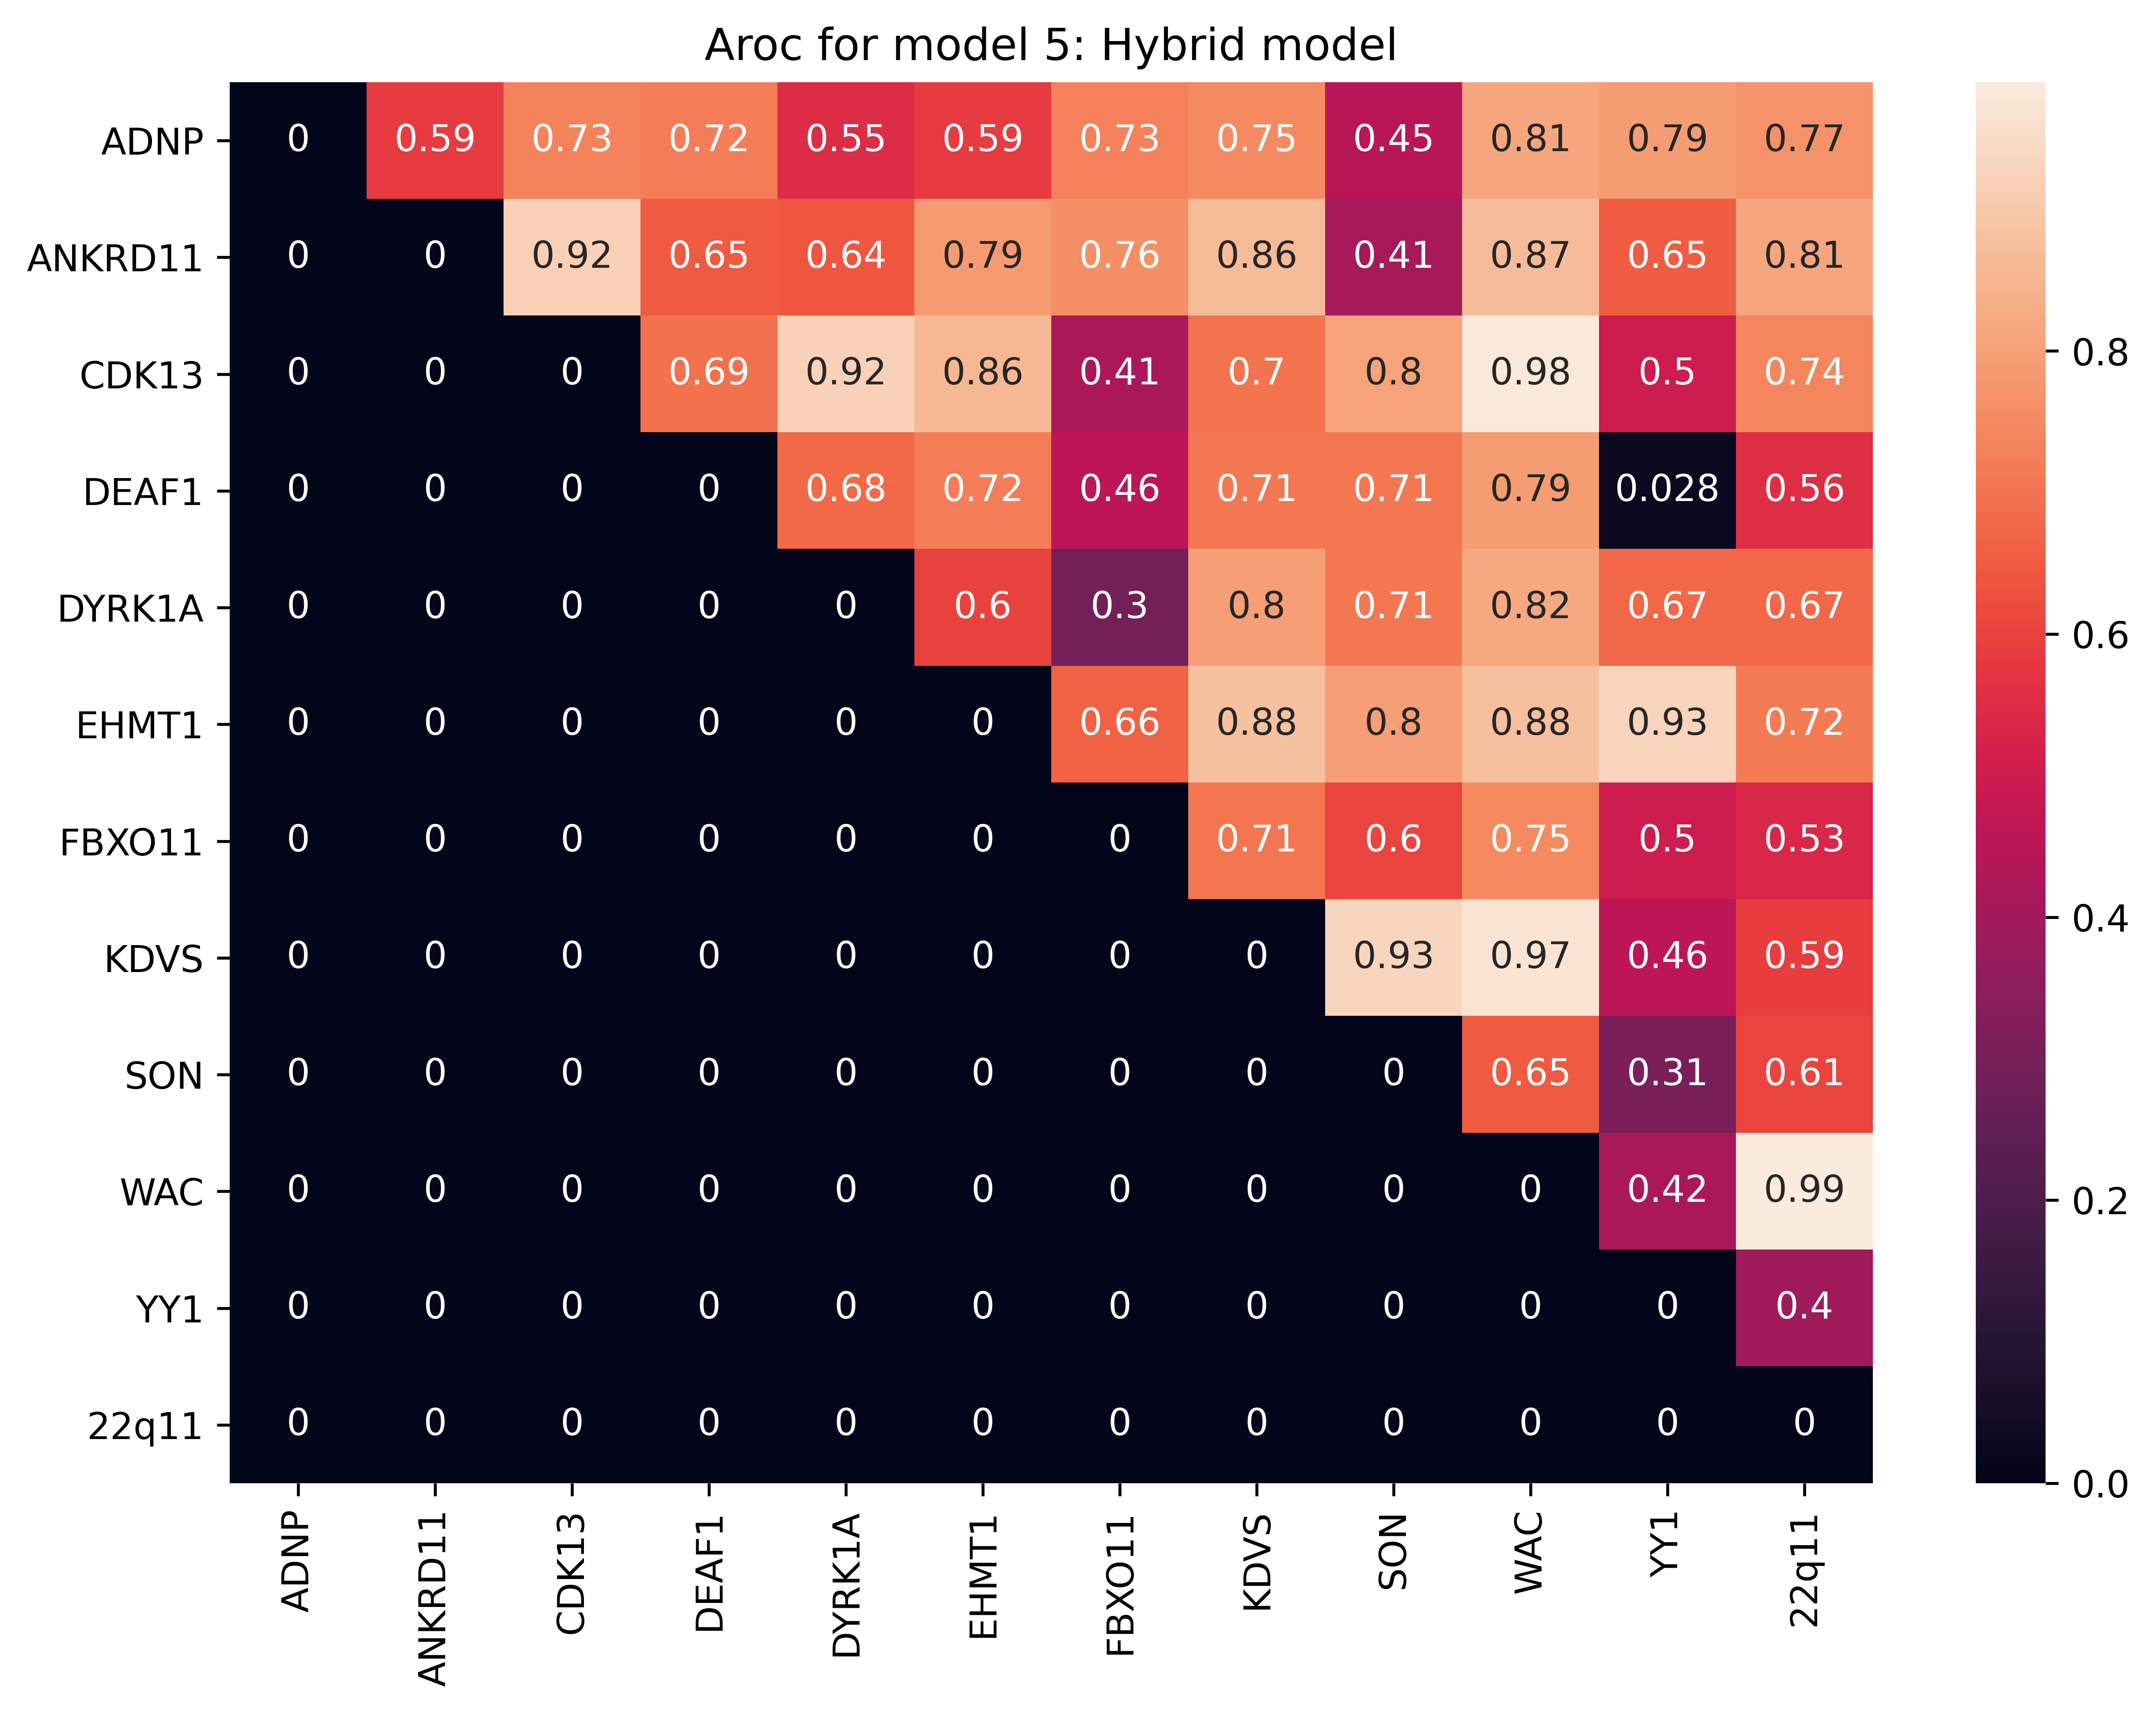

In [16]:
labels = print(list(range(len(syn_list))))

# # deepface_all
# df_cm = pd.DataFrame(results_df_all, syn_list, syn_list)
# plt.figure(figsize = (10,7), dpi=600)
# plt.title("Aroc for model 1: Deepface model")
# sn.heatmap(df_cm, annot=True)
# plt.savefig("results/aroc-deepface.png")

# pointnet
# df_cm = pd.DataFrame(results_pn, syn_list, syn_list)
# plt.figure(figsize = (10,7), dpi=600)
# plt.title("Aroc for model 2: FaceReader PointNet model")
# sn.heatmap(df_cm, annot=True)
# plt.savefig("results/aroc-facereader-pointnet.png")

# # randomforest
# df_cm = pd.DataFrame(results_rf, syn_list, syn_list)
# plt.figure(figsize = (10,7), dpi=600)
# plt.title("Aroc for model 3: FaceReader distance model")
# sn.heatmap(df_cm, annot=True)
# plt.savefig("results/aroc-facereader-distance.png")

# # ensemble
# df_cm = pd.DataFrame(results_en, syn_list, syn_list)        
# plt.figure(figsize = (10,7), dpi=600)
# plt.title("Aroc for model 4: Ensemble model")
# sn.heatmap(df_cm, annot=True)
# plt.savefig("results/aroc-ensemble.png")

# # openface-cfps
df_cm = pd.DataFrame(results_oc, syn_list, syn_list)        
plt.figure(figsize = (10,7), dpi=600)
plt.title("Aroc for model 5: Hybrid model")
sn.heatmap(df_cm, annot=True)
plt.savefig("results/aroc-hybrid.png")